<a href="https://colab.research.google.com/github/KL2300030695/FER2013/blob/main/FER2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Facial Emotion Detection**

#*📌* Step 1: Setup & Download

In [6]:
!pip install opendatasets torch torchvision matplotlib seaborn

import opendatasets as od
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Download dataset
dataset_url = "https://www.kaggle.com/datasets/msambare/fer2013"
od.download(dataset_url)

data_dir = Path("fer2013")
print("Contents:", os.listdir(data_dir))


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mraudaciousgamerchef
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:00<00:00, 1.34GB/s]

Contents: ['train', 'test']


#📌 Step 2: Explore Dataset + Show Samples

Train classes: ['fear', 'neutral', 'angry', 'surprise', 'sad', 'disgust', 'happy']
Val classes: ['fear', 'neutral', 'angry', 'surprise', 'sad', 'disgust', 'happy']


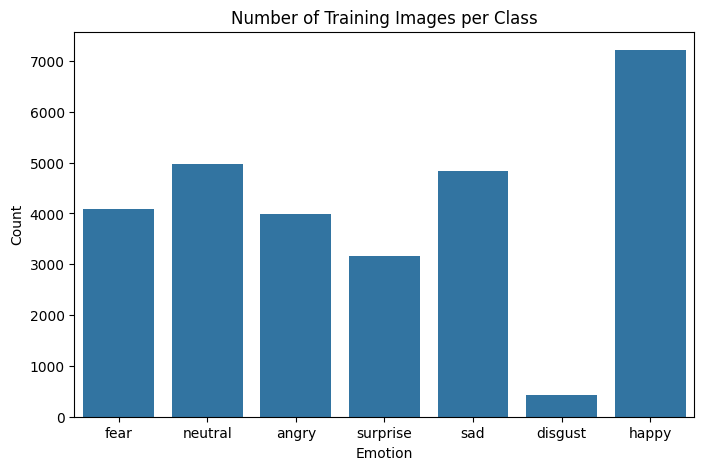

In [7]:
train_dir = data_dir / "train"
val_dir   = data_dir / "test"

print("Train classes:", os.listdir(train_dir))
print("Val classes:", os.listdir(val_dir))

# Count images per class
class_counts = {cls: len(os.listdir(train_dir/cls)) for cls in os.listdir(train_dir)}
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Number of Training Images per Class")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


#IMAGES

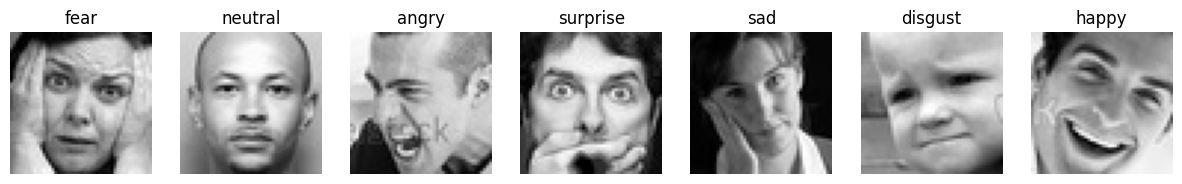

In [8]:
from PIL import Image

fig, axes = plt.subplots(1, 7, figsize=(15,3))
for i, cls in enumerate(os.listdir(train_dir)):
    img_path = list((train_dir/cls).glob("*.jpg"))[0]  # pick first image
    img = Image.open(img_path)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(cls)
    axes[i].axis("off")
plt.show()


#📌 Step 3: DataLoader & Transforms

Train size: 28709
Val size: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


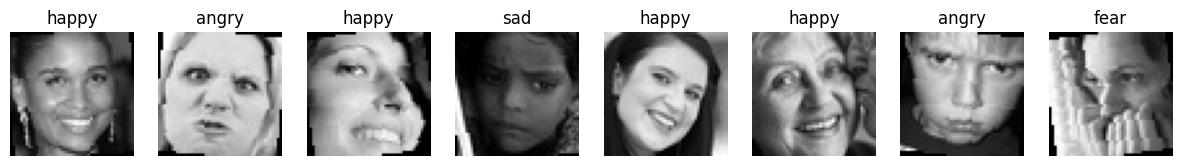

In [9]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # grayscale
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_transform)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Classes:", train_ds.classes)

# Show a batch of images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(15,3))
for i in range(8):
    axes[i].imshow(images[i][0], cmap="gray")
    axes[i].set_title(train_ds.classes[labels[i]])
    axes[i].axis("off")
plt.show()


#📌 Part 4: CNN Model + Training Progress

In [62]:
# ================== Imports ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

# ================== Device ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [70]:
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np

# ================== Data Transforms ==================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # FER2013 is grayscale, ResNet needs 3 channels
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# ================== Dataset ==================
full_ds = datasets.ImageFolder("fer2013/train", transform=train_transform)

# Train/Val split
train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

# Apply val transforms
val_ds.dataset.transform = val_transform

# ================== Weighted Sampling ==================
targets = [full_ds.samples[i][1] for i in train_ds.indices]   # only training part
class_counts = np.bincount(targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# ================== Data Loaders ==================
train_loader = DataLoader(train_ds, batch_size=64, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 359
Val batches: 90


#Step 5: Load ResNet-18 (Pretrained)

In [71]:


# ================== Model ==================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace FC with dropout + batchnorm
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 7)   # 7 emotions
)

model = model.to(device)


#Step 6: Loss & *Optimizer*

In [72]:

# ================== Loss & Optimizer ==================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#Step 7: Training Loop

In [73]:


# ================== Training Function ==================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        running_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        scheduler.step()

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    return history



In [74]:

# ================== Run Training ==================
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)



Epoch 1/30 | Train Loss: 1.7692, Acc: 0.3058 | Val Loss: 1.7496, Acc: 0.2976
Epoch 2/30 | Train Loss: 1.6028, Acc: 0.3804 | Val Loss: 1.7235, Acc: 0.3123
Epoch 3/30 | Train Loss: 1.5373, Acc: 0.4014 | Val Loss: 1.7005, Acc: 0.3194
Epoch 4/30 | Train Loss: 1.4837, Acc: 0.4324 | Val Loss: 1.6737, Acc: 0.3440
Epoch 5/30 | Train Loss: 1.4542, Acc: 0.4385 | Val Loss: 1.6889, Acc: 0.3319
Epoch 6/30 | Train Loss: 1.4250, Acc: 0.4515 | Val Loss: 1.6927, Acc: 0.3255
Epoch 7/30 | Train Loss: 1.4060, Acc: 0.4552 | Val Loss: 1.6673, Acc: 0.3422
Epoch 8/30 | Train Loss: 1.3941, Acc: 0.4611 | Val Loss: 1.6707, Acc: 0.3394
Epoch 9/30 | Train Loss: 1.3697, Acc: 0.4725 | Val Loss: 1.6679, Acc: 0.3358
Epoch 10/30 | Train Loss: 1.3627, Acc: 0.4722 | Val Loss: 1.6578, Acc: 0.3483
Epoch 11/30 | Train Loss: 1.3396, Acc: 0.4803 | Val Loss: 1.6562, Acc: 0.3504
Epoch 12/30 | Train Loss: 1.3276, Acc: 0.4871 | Val Loss: 1.6447, Acc: 0.3537
Epoch 13/30 | Train Loss: 1.3121, Acc: 0.4932 | Val Loss: 1.6405, Acc: 0.

#Step 8: Plot Training Curves

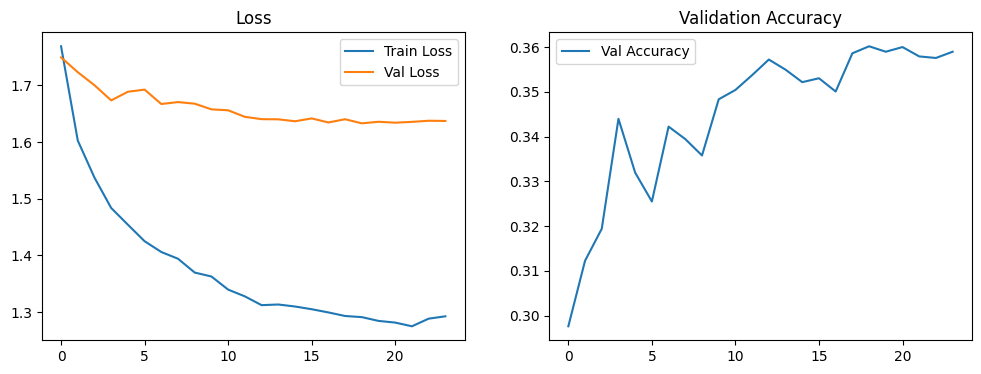

In [75]:
# ================== Plot History ==================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

#Step 9: Model Summary

In [38]:
!pip install torchsummary

from torchsummary import summary


In [39]:
from torchsummary import summary
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace last FC layer with 7 outputs
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

# Send model to device
model = model.to(device)

# Now summary uses same device
summary(model, (3, 224, 224), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#Newer Version for TorchSummary

In [40]:
!pip install torchinfo
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224))  # batch_size=32


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 7]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [79]:
from google.colab import files
uploaded = files.upload()   # select multiple images


Saving img.jpg to img (2).jpg


In [80]:
for fname in uploaded.keys():
    image_path = "/content/" + fname
    pred = predict_emotion(image_path, model)
    print(f"{fname} → {pred}")


img (2).jpg → Sad


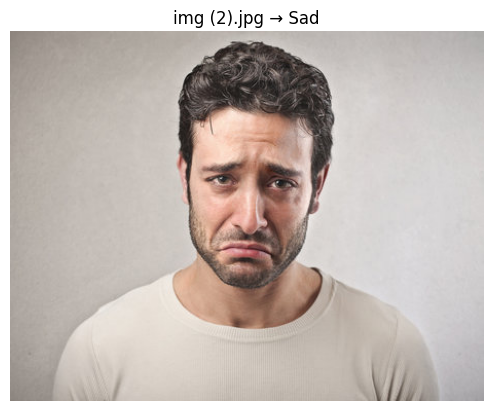

In [81]:
import matplotlib.pyplot as plt

for fname in uploaded.keys():   # or os.listdir(folder_path)
    image_path = "/content/" + fname
    pred = predict_emotion(image_path, model)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"{fname} → {pred}")
    plt.axis("off")
    plt.show()
